# The Extended Kalman Filter

선형 칼만 필터 (Linear Kalman Filter)에 대한 이론을 바탕으로 비선형 문제에 칼만 필터를 적용해 보겠습니다. 확장칼만필터 (EKF)는 예측단계와 추정단계의 데이터를 비선형으로 가정하고 현재의 추정값에 대해 시스템을 선형화 한뒤 선형 칼만 필터를 사용하는 기법입니다.

비선형 문제에 적용되는 성능이 더 좋은 알고리즘들 (UKF, H_infinity)이 있지만 EKF 는 아직도 널리 사용되서 관련성이 높습니다.

In [1]:
%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Linearizing the Kalman Filter

### Non-linear models
칼만 필터는 시스템이 선형일것이라는 가정을 하기 때문에 비선형 문제에는 직접적으로 사용하지 못합니다. 비선형성은 두가지 원인에서 기인될수 있는데 첫째는 프로세스 모델의 비선형성 그리고 둘째 측정 모델의 비선형성입니다. 예를 들어, 떨어지는 물체의 가속도는 속도의 제곱에 비례하는 공기저항에 의해 결정되기 때문에 비선형적인 프로세스 모델을 가지고, 레이더로 목표물의 범위와 방위 (bearing) 를 측정할때 비선형함수인 삼각함수를 사용하여 표적의 위치를 계산하기 때문에 비선형적인 측정 모델을 가지게 됩니다.

비선형문제에 기존의 칼만필터 방정식을 적용하지 못하는 이유는 비선형함수에 정규분포 (Gaussian)를 입력하면 아래와 같이 Gaussian 이 아닌 분포를 가지게 되기 때문입니다. 

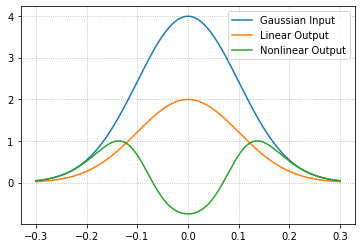

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

mu, sigma = 0, 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 10000)
gaussian = stats.norm.pdf(x, mu, sigma)

def nonlinearFunction(x):
    return np.sin(x)

def linearFunction(x):
    return 0.5*x

nonlinearOutput = nonlinearFunction(gaussian)
linearOutput = linearFunction(gaussian)

# print(x)    
    
plt.plot(x, gaussian, label = 'Gaussian Input')
plt.plot(x, linearOutput, label = 'Linear Output')
plt.plot(x, nonlinearOutput, label = 'Nonlinear Output')

plt.grid(linestyle='dotted', linewidth=0.8)
plt.legend()
plt.show()

### System Equations
선형 칼만 필터의 경우 프로세스 및 측정 모델은 다음과 같이 나타낼수 있습니다.

$$\begin{aligned}\dot{\mathbf x} &= \mathbf{Ax} + w_x\\
\mathbf z &= \mathbf{Hx} + w_z
\end{aligned}$$

이때 $\mathbf A$ 는 (연속시간에서) 시스템의 역학을 묘사하는 dynamic matrix 입니다. 위의 식을 이산화(discretize)시키면 아래와 같이 나타내줄 수 있습니다. 

$$\begin{aligned}\bar{\mathbf x}_k &= \mathbf{F} \mathbf{x}_{k-1} \\
\bar{\mathbf z} &= \mathbf{H} \mathbf{x}_{k-1}
\end{aligned}$$

이때 $\mathbf F$ 는 이산시간 $\Delta t$ 에 걸쳐 $\mathbf x_{k-1}$을 $\mathbf x_{k}$ 로 전환하는 상태변환행렬 또는 상태전달함수 (state transition matrix) 이고, 위에서의 $w_x$ 와 $w_z$는 각각 프로세스 노이즈 공분산 행렬 $\mathbf Q$ 과 측정 노이즈 공분산 행렬 $\mathbf R$ 에 포함됩니다.

선형 시스템에서의 $\mathbf F \mathbf x- \mathbf B \mathbf u$ 와 $\mathbf H \mathbf x$ 는 비선형 시스템에서 함수 $f(\mathbf x, \mathbf u)$ 와 $h(\mathbf x)$ 로 대체됩니다.

$$\begin{aligned}\dot{\mathbf x} &= f(\mathbf x, \mathbf u) + w_x\\
\mathbf z &= h(\mathbf x) + w_z
\end{aligned}$$

### Linearisation
선형화란 말그대로 하나의 시점에 대하여 비선형함수에 가장 가까운 선 (선형시스템) 을 찾는것이라고 볼수 있습니다. 여러가지 방법으로 선형화를 할수 있겠지만 흔히 일차 테일러 급수를 사용합니다. ($ c_0$ 과 $c_1 x$)

$$f(x) = \sum_{k=0}^\infty c_k x^k = c_0 + c_1 x + c_2 x^2 + \dotsb$$
$$c_k = \frac{f^{\left(k\right)}(0)}{k!} = \frac{1}{k!} \cdot \frac{d^k f}{dx^k}\bigg|_0 $$

행렬의 미분값을 Jacobian 이라고 하는데 이를 통해서 위와 같이 $\mathbf F$ 와 $\mathbf H$ 를 나타낼 수 있습니다.

$$
\begin{aligned}
\mathbf F 
= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \;\;\;\;
\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

$$\mathbf F = \frac{\partial f(\mathbf x, \mathbf u)}{\partial x} =\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \dots & \frac{\partial f_1}{\partial x_n}\\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \dots & \frac{\partial f_2}{\partial x_n} \\
\\ \vdots & \vdots & \ddots & \vdots
\\
\frac{\partial f_n}{\partial x_1} & \frac{\partial f_n}{\partial x_2} & \dots & \frac{\partial f_n}{\partial x_n}
\end{bmatrix}
$$

Linear Kalman Filter 와 Extended Kalman Filter 의 식들을 아래와 같이 비교할수 있습니다.

$$\begin{array}{l|l}
\text{Linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

$\mathbf F \mathbf x_{k-1}$ 을 사용하여 $\mathbf x_{k}$의 값을 추정할수 있겠지만, 선형화 과정에서 오차가 생길수 있기 때문에 Euler 또는 Runge Kutta 수치 적분 (numerical integration) 을 통해서 사전추정값 $\mathbf{\bar{x}}$ 를 구합니다. 같은 이유로 $\mathbf y$ (innovation vector 또는 잔차(residual)) 를 구할때도 $\mathbf H \mathbf x$ 대신에 수치적인 방법으로 계산하게 됩니다.

## Example: Robot Localization

### Prediction Model (예측모델)
EKF를 4륜 로봇에 적용시켜 보겠습니다. 간단한 bicycle steering model 을 통해 아래의 시스템 모델을 나타낼 수 있습니다.

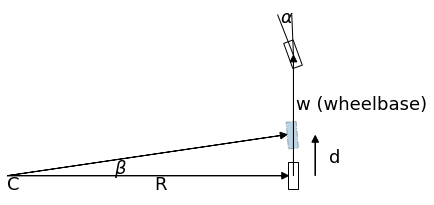

In [3]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.plot_bicycle()

$$\begin{aligned} 
\beta &= \frac d w \tan(\alpha) \\
\bar x_k &= x_{k-1} - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y_k &= y_{k-1} + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta_k &= \theta_{k-1} + \beta
\end{aligned}
$$

위의 식들을 토대로 상태벡터를 $\mathbf{x}=[x, y, \theta]^T$ 그리고 입력벡터를 $\mathbf{u}=[v, \alpha]^T$ 라고 정의 해주면 아래와 같이 $f(\mathbf x, \mathbf u)$ 나타내줄수 있고 $f$ 의 Jacobian $\mathbf F$를 미분하여 아래의 행렬을 구해줄수 있습니다.

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$

$$f = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

$$\mathbf F = \frac{\partial f(\mathbf x, \mathbf u)}{\partial \mathbf x} = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

$\bar{\mathbf P}$ 을 구하기 위해 입력($\mathbf u$)에서 비롯되는 프로세스 노이즈 $\mathbf Q$ 를 아래와 같이 정의합니다.

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}
\;\;\;\;
\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \alpha} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \alpha} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \alpha}
\end{bmatrix}$$

$$\mathbf{\bar P} =\mathbf{FPF}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}$$


In [4]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v*time
beta = (d/w)*sympy.tan(alpha)
r = w/sympy.tan(alpha)

fxu = Matrix([[x-r*sympy.sin(theta) + r*sympy.sin(theta+beta)],
              [y+r*sympy.cos(theta)- r*sympy.cos(theta+beta)],
              [theta+beta]])
F = fxu.jacobian(Matrix([x, y, theta]))
F

⎡                        ⎛t⋅v⋅tan(α)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(α)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

In [5]:
# reduce common expressions
B, R = symbols('beta, R')
F = F.subs((d/w)*sympy.tan(alpha), B)
F.subs(w/sympy.tan(alpha), R)

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

In [6]:
V = fxu.jacobian(Matrix([v, alpha]))
V = V.subs(sympy.tan(alpha)/w, 1/R) 
V = V.subs(time*v/R, B)
V = V.subs(time*v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

### Measurement Model (측정모델)

레이더로 범위$(r)$와 방위($\phi$)를 측정할때 다음과 같은 센서모델을 사용합니다. 이때 $\mathbf p$ 는 landmark의 위치를 나타내줍니다.

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}
\;\;\;\;
\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta
$$

$$\begin{aligned}
\mathbf z& = h(\bar{\mathbf x}, \mathbf p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

$h$ 의 Jacobian $\mathbf H$를 미분하여 아래의 행렬을 구해줄수 있습니다.
$$\mathbf H = \frac{\partial h(\mathbf x, \mathbf u)}{\partial \mathbf x} =
\left[\begin{matrix}\frac{- p_{x} + x}{\sqrt{\left(p_{x} - x\right)^{2} + \left(p_{y} - y\right)^{2}}} & \frac{- p_{y} + y}{\sqrt{\left(p_{x} - x\right)^{2} + \left(p_{y} - y\right)^{2}}} & 0\\- \frac{- p_{y} + y}{\left(p_{x} - x\right)^{2} + \left(p_{y} - y\right)^{2}} & - \frac{p_{x} - x}{\left(p_{x} - x\right)^{2} + \left(p_{y} - y\right)^{2}} & -1\end{matrix}\right]
$$

In [7]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta

px, py = sympy.symbols('p_x, p_y')
z = sympy.Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(sympy.Matrix([x, y, theta]))

# print(sympy.latex(z.jacobian(sympy.Matrix([x, y, theta])))

⎡          -pₓ + x                      -p_y + y             ⎤
⎢───────────────────────────  ───────────────────────────  0 ⎥
⎢   ________________________     ________________________    ⎥
⎢  ╱         2            2     ╱         2            2     ⎥
⎢╲╱  (pₓ - x)  + (p_y - y)    ╲╱  (pₓ - x)  + (p_y - y)      ⎥
⎢                                                            ⎥
⎢       -(-p_y + y)                   -(pₓ - x)              ⎥
⎢  ──────────────────────       ──────────────────────     -1⎥
⎢          2            2               2            2       ⎥
⎣  (pₓ - x)  + (p_y - y)        (pₓ - x)  + (p_y - y)        ⎦

In [8]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

In [9]:
from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

측정 노이즈는 다음과 같이 나타내줍니다.
$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

`FilterPy` 의 `ExtendedKalmanFilter` class 를 활용해서 EKF 를 구현해보도록 하겠습니다.

In [10]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt, random
import sympy

class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = sympy.symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = sympy.Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(sympy.Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(sympy.Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

정확한 잔차값 $y$을 구하기 방위값이 $0 \leq \phi \leq 2\pi$ 이도록 고쳐줍니다.

In [11]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

In [12]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + random.randn()*std_rng],
                  [a + random.randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian = H_of, Hx = Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01]) 

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

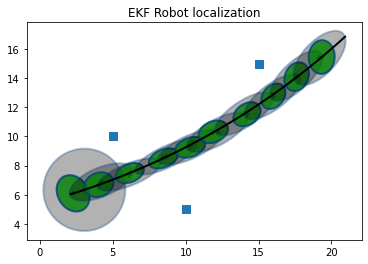

Final P: [0.02384365 0.04227408 0.00219898]


In [13]:
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

## References

* Roger R Labbe, Kalman and Bayesian Filters in Python
(https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/11-Extended-Kalman-Filters.ipynb)
* https://blog.naver.com/jewdsa813/222200570774